In [13]:
import os
import sys
import scipy.io
import glob
import cv2
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.models import load_model
import pprint
%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

STYLE_LAYERS = [
    ('conv2_block1_1_conv', 0.2),
    ('conv3_block1_1_conv', 0.2),
    ('conv4_block1_1_conv', 0.2),
    ('conv5_block1_1_conv', 0.2)]



def find_h5_file(folder):
    for filepath in glob.glob(folder + '\*'):
        filename = filepath.split('\\')[-1]
        if '.h5' in filename:
            return filename

def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_C, n_H*n_W])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_C, n_H*n_W])
    
    # compute the cost with tensorflow (≈1 line)
    J_content =  (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    ### END CODE HERE
    
    return J_content


def gram_matrix(A):
    ### START CODE HERE
    #(≈1 line)
    
    GA = tf.matmul(A, tf.transpose(A))
    
    ### END CODE HERE

    return GA


def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, shape = [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape = [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # Computing the loss (≈1 line)
    J_style_layer = (1/(4*(n_C**2)*((n_H*n_W)**2)))*tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(GS,GG))))
    
    ### END CODE HERE
    
    return J_style_layer

def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not to be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the array contains the content layer image, which must not to be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style


def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    ### START CODE HERE
    
    #(≈1 line)
    J = alpha*J_content + beta*J_style
    
    ### START CODE HERE

    return J

def get_layer_outputs(model, layer_names):
    """ Creates a model that returns a list of intermediate output values."""
    outputs = [model.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([model.input], outputs)
    return model

def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [2]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = (260,110)


model_version = 47
weights_version = find_h5_file(r'D:\Daniel\PMD\scripts\H5 to UFF\pmd_v{}'.format(model_version))
model_path = r"D:\Daniel\PMD\scripts\H5 to UFF\pmd_v{}\{}".format(model_version, weights_version)
model = load_model(model_path)

model.trainable = False
pp.pprint(model)

In [3]:
for layer in model.layers:
    print(layer.name)

input_1
zero_padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3_b

In [4]:
model.get_layer('conv5_block1_1_conv').output


<KerasTensor: shape=(None, 8, 3, 128) dtype=float32 (created by layer 'conv5_block1_1_conv')>

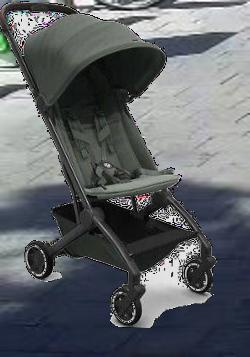

In [5]:
# Content Image
content_path = r"C:\Users\USER\Downloads\18_1-300x300.jpg"
content_path = r"C:\Users\USER\Downloads\1.jpg"
content_image_display = Image.open(content_path)
orig_img_size = content_image_display.size
content_image_display



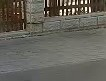

In [6]:
# Style Image
style_path = r"I:\Daniel\Israel Footage\extracted images\extracted\day extracted\cam4-25_08_2021 08_59_59 (UTC+03_00)_0005.avi\frame0108.jpg"
style_path = r"C:\Users\USER\Downloads\1356338.mp4_04.jpg"
style_display = Image.open(style_path)
style_display

(1, 260, 110, 3)


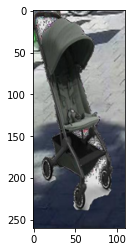

In [7]:
content_image = np.array(Image.open(content_path).resize((img_size[1], img_size[0])))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 260, 110, 3)


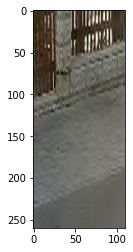

In [8]:
style_image = np.array(Image.open(style_path).resize((img_size[1], img_size[0])))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 260, 110, 3)


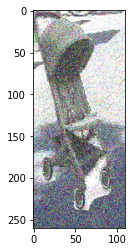

In [9]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min =0, clip_value_max=1)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [10]:
content_layer = [('conv5_block1_1_conv', 1)]

model_outputs = get_layer_outputs(model, STYLE_LAYERS + content_layer)

In [17]:
content_target = model_outputs(content_image)
style_targets = model_outputs(style_image)

In [18]:
preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = model_outputs(preprocessed_content)

a_G = model_outputs(generated_image)

J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.00014880627, shape=(), dtype=float32)


In [19]:
preprocessed_style = tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = model_outputs(preprocessed_style)

J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(0.00054304017, shape=(), dtype=float32)


In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the model_outputs for the current generated image
        
        ### START CODE HERE
        
        #(1 line)
        a_G = model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha=20, beta=30)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    # generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

Epoch 0 


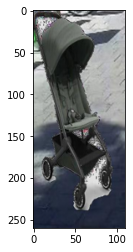

Epoch 250 


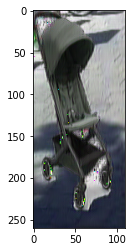

Epoch 500 


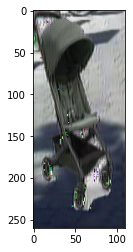

Epoch 750 


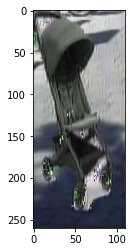

Epoch 1000 


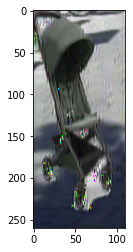

Epoch 1250 


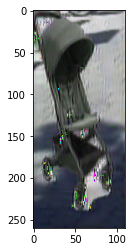

Epoch 1500 


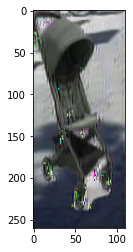

In [21]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

epochs = 1501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        # image.save(f"output/image_{i}.jpg")
        plt.show() 

(1, 357, 250, 3)


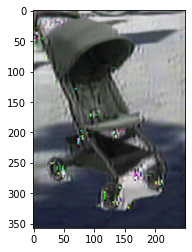

In [22]:
NST_image = np.array(image.resize((orig_img_size[0], orig_img_size[1])))
NST_image = tf.constant(np.reshape(NST_image, ((1,) + NST_image.shape)))

print(NST_image.shape)
imshow(NST_image[0])
plt.show()
# image

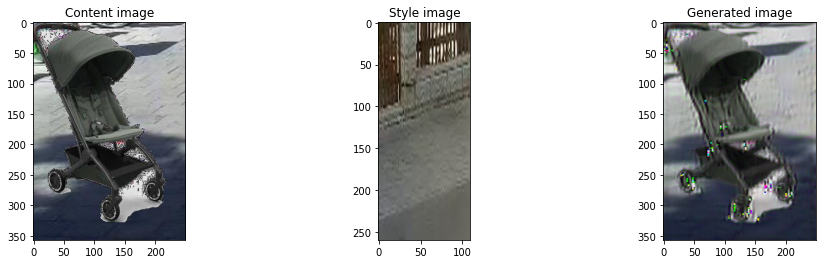

In [23]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image_display)
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(NST_image[0])
ax.title.set_text('Generated image')
plt.show()